<a href="https://colab.research.google.com/github/TianrunCheng/hello-world/blob/master/FinalProject_RNN_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center"> Tweet Sentiment Extraction </div>
<div align="center"> Tianrun Cheng &emsp;&emsp; Sibo Dong &emsp;&emsp; Qing Zhou </div>
<div align="right"> Apr 2020 </div>

## 1. Data Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import os, sys, time, datetime, re
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from collections import Counter
import torch
from torch.utils.data import TensorDataset, DataLoader

train = pd.read_csv('./data/train.csv')
print('Total train num: ', len(train))
train = train.dropna()
print('Valid train num: ', len(train))

train_textID = train.textID.tolist()
train_text = train.text.tolist()
train_selected_text = train.selected_text.tolist()
train_sentiment = train.sentiment.tolist()

test = pd.read_csv('./data/test.csv')
print('Total test num: ', len(test))
test = test.dropna()
print('Valid test num: ', len(test))

test_textID = test.textID.tolist()
test_text = test.text.tolist()
test_sentiment = test.sentiment.tolist()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Total train num:  27486
Valid train num:  27485
Total test num:  3535
Valid test num:  3535


In [ ]:
train_text_tk = []
train_selected_text_tk = []
train_sentiment_int = []
train_text_len = []
train_selected_text_len = []

test_text_tk = []
test_sentiment_int = []
test_text_len = []

words = []
senti = {'positive': 1, 'negative': 2, 'neutral':0}

for i,sen in enumerate(train_text):
    w = word_tokenize(sen.lower())
    ws = word_tokenize(train_selected_text[i].lower())
    words += w
    words += ws
    train_text_tk.append(w)
    train_selected_text_tk.append(ws)
    train_sentiment_int.append(senti[train_sentiment[i]])
    train_text_len.append(len(w))
    train_selected_text_len.append(len(ws))
    
for i,sen in enumerate(test_text):
    w = word_tokenize(sen.lower())
    words += w
    test_text_tk.append(w)
    test_sentiment_int.append(senti[test_sentiment[i]])
    test_text_len.append(len(w))
    
## Build a dictionary that maps words to integers
counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 3)}

print('Unique words: ', len((vocab_to_int)))

Unique words:  32691


In [ ]:
print(vocab_to_int)

{'i': 3, '!': 4, '.': 5, '`': 6, 'to': 7, 'the': 8, ',': 9, 'a': 10, 'my': 11, 'it': 12, 'you': 13, '*': 14, 'and': 15, '?': 16, 'is': 17, 'in': 18, '...': 19, 's': 20, 'for': 21, 't': 22, 'of': 23, 'that': 24, 'me': 25, 'on': 26, 'so': 27, 'have': 28, 'but': 29, 'm': 30, 'just': 31, 'not': 32, 'with': 33, 'day': 34, 'be': 35, ':': 36, 'at': 37, 'good': 38, 'was': 39, '..': 40, 'can': 41, 'all': 42, 'this': 43, 'now': 44, 'out': 45, 'up': 46, 'get': 47, 'no': 48, 'like': 49, 'are': 50, 'love': 51, 'go': 52, 'got': 53, 'happy': 54, 'do': 55, 'too': 56, 'work': 57, '-': 58, 'your': 59, 'today': 60, 'going': 61, 'http': 62, 'what': 63, 'we': 64, 'lol': 65, 'one': 66, 'time': 67, 'u': 68, 'from': 69, 'know': 70, 'don': 71, 'really': 72, 'will': 73, 'back': 74, 'there': 75, 'im': 76, 'about': 77, 'its': 78, 'am': 79, 'see': 80, ')': 81, 'had': 82, 'if': 83, 'some': 84, 'thanks': 85, 'they': 86, '&': 87, 'night': 88, 'want': 89, 'well': 90, 'miss': 91, 'home': 92, 'new': 93, '(': 94, 'how': 

In [ ]:
print(train_text_tk[:10])
print(train_selected_text_tk[:10])
print(train_sentiment_int[:10])

print(test_text_tk[:10])
print(test_sentiment_int[:10])

print('average/max/min len of train text: %5.2f%5d%3d' % (np.mean(train_text_len), np.max(train_text_len), np.min(train_text_len)))
print('average/max/min len of train selected text: %5.2f%5d%3d' % (np.mean(train_selected_text_len), np.max(train_selected_text_len), np.min(train_selected_text_len)))
print('average/max/min len of test  text: %5.2f%5d%3d' % (np.mean(test_text_len), np.max(test_text_len), np.min(test_text_len)))

[['spent', 'the', 'entire', 'morning', 'in', 'a', 'meeting', 'w/', 'a', 'vendor', ',', 'and', 'my', 'boss', 'was', 'not', 'happy', 'w/', 'them', '.', 'lots', 'of', 'fun', '.', 'i', 'had', 'other', 'plans', 'for', 'my', 'morning'], ['oh', '!', 'good', 'idea', 'about', 'putting', 'them', 'on', 'ice', 'cream'], ['says', 'good', '(', 'or', 'should', 'i', 'say', 'bad', '?', ')', 'afternoon', '!', 'http', ':', '//plurk.com/p/wxpdj'], ['i', 'dont', 'think', 'you', 'can', 'vote', 'anymore', '!', 'i', 'tried'], ['haha', 'better', 'drunken', 'tweeting', 'you', 'mean', '?'], ['headache', 'wan', 'na', 'see', 'my', 'julie'], ['had', 'an', 'awsome', 'salad', '!', 'i', 'recommend', 'getting', 'the', 'spicey', 'buffalo', 'chicken', 'salad', '!'], ['fine', '!', 'going', 'to', 'do', 'my', 'big', 'walk', 'today', '20', 'or', 'so', 'miles'], ['thank', 'a', 'yoou', 'how', 'are', 'you', '?', '#', 'twittertakeover'], ['why', 'do', "n't", 'adobe', 'realise', 'no', 'one', 'wants', 'to', 'pay', 'for', 'photosho

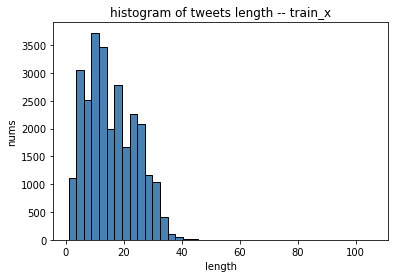

In [ ]:
import matplotlib.pyplot as plt
plt.hist(x = train_text_len, # 指定绘图数据
         bins = 40, # 指定直方图中条块的个数
         color = 'steelblue', # 指定直方图的填充色
         edgecolor = 'black' # 指定直方图的边框色
         )
# 添加x轴和y轴标签
plt.xlabel('length')
plt.ylabel('nums')
# 添加标题
plt.title('histogram of tweets length -- train_x')
# 显示图形
plt.show()

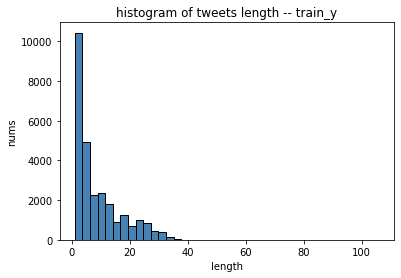

In [ ]:
plt.hist(x = train_selected_text_len, # 指定绘图数据
         bins = 40, # 指定直方图中条块的个数
         color = 'steelblue', # 指定直方图的填充色
         edgecolor = 'black' # 指定直方图的边框色
         )
# 添加x轴和y轴标签
plt.xlabel('length')
plt.ylabel('nums')
# 添加标题
plt.title('histogram of tweets length -- train_y')
# 显示图形
plt.show()

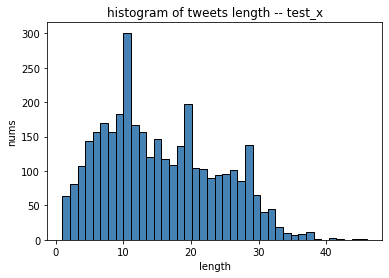

In [ ]:
plt.hist(x = test_text_len, # 指定绘图数据
         bins = 40, # 指定直方图中条块的个数
         color = 'steelblue', # 指定直方图的填充色
         edgecolor = 'black' # 指定直方图的边框色
         )
# 添加x轴和y轴标签
plt.xlabel('length')
plt.ylabel('nums')
# 添加标题
plt.title('histogram of tweets length -- test_x')
# 显示图形
plt.show()

In [ ]:
train_text_emb = []
train_selected_text_emb = []
   = []
test_text_emb = []
for i,sen in enumerate(train_text_tk):
    text_emb = [vocab_to_int[word] for word in sen]
    train_text_emb.append(text_emb)
    
    text_s_emb = [vocab_to_int[word] for word in train_selected_text_tk[i]]
    train_selected_text_emb.append(text_s_emb)
    w_label = []
    for w in text_emb:
        if w in text_s_emb:
            w_label.append(1)
        else:
            w_label.append(0)
    train_label.append(w_label)
#for i,sen in enumerate(train_selected_text_tk):
#    train_selected_text_emb.append([vocab_to_int[word] for word in sen])

for i,sen in enumerate(test_text_tk):
    test_text_emb.append([vocab_to_int[word] for word in sen])
    
print(train_text_emb[11:20])
print(train_label[11:20])
print(train_selected_text_emb[11:20])
print(train_sentiment_int[11:20])

#print(test_text_emb[11:20])
#print(test_sentiment_int[11:20])

[[5798, 97, 8, 189, 6, 2147, 153, 4, 38, 6, 32, 86, 105, 3537, 8, 43, 8, 3, 261, 10386, 13, 86, 10387, 34, 834, 17, 9, 150, 4], [92, 12, 10, 678], [26, 31, 602, 9, 460, 8360, 18, 10, 750, 5, 106, 106, 5, 3, 1419, 9, 1253], [280, 398, 57, 29, 18, 141, 744, 687], [60, 2329, 602, 23, 1819, 10388, 13, 7, 2004, 3811, 5799, 4, 8361, 6, 179, 106, 477, 20659, 2005, 4, 282, 8, 10, 1073, 16, 34, 54, 5, 448, 5], [2825, 3129, 324, 34, 40], [1254, 130, 226, 14, 189, 48, 1074, 223], [27, 3, 26, 49, 48, 105, 236, 11, 19, 425, 119], [3, 26, 10389, 7, 116, 5086, 1043, 13, 11, 16, 40, 5, 57, 125, 3, 357, 1304, 6, 58]]
[[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 1, 1], [0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
def pad_features(text_emb, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's 
        or truncated to the input seq_length.
    '''
    
    # getting the correct rows x cols shape
    features = np.zeros((len(text_emb), seq_length), dtype=int)
 
    # for each review, I grab that review and 
    for i, row in enumerate(text_emb):
        features[i, -len(row):] = np.array(row)[:seq_length]
    
    return features
 
seq_length = 40
 
train_x = pad_features(train_text_emb, seq_length=seq_length)
train_y = pad_features(train_selected_text_emb, seq_length=seq_length)
train_y = pad_features(train_label, seq_length=seq_length+1)
test_x = pad_features(test_text_emb, seq_length=seq_length)
 
## test statements - do not change - ##
assert len(train_x)==len(train_text_emb), "Your features should have as many rows as reviews."
assert len(train_x[0])==seq_length, "Each feature row should contain seq_length values."

train_x = [np.insert(train_x[i], 0 ,train_sentiment_int[i]) for i  in range(len(train_sentiment_int))]
train_x = np.array(train_x)

#print(type(train_x[0]), type(train_x))
print(train_x[11:20])
print(train_y[11:20])

[[    0     0     0     0     0     0     0     0     0     0     0     0
   5798    97     8   189     6  2147   153     4    38     6    32    86
    105  3537     8    43     8     3   261 10386    13    86 10387    34
    834    17     9   150     4]
 [    2     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0    92    12    10   678]
 [    1     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
     26    31   602     9   460  8360    18    10   750     5   106   106
      5     3  1419     9  1253]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0   280   398    57
     29    18

In [ ]:
## for kaggle online submission -- no test_y

batch_size = 100
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
 
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample output: \n', sample_y)

Sample input size:  torch.Size([100, 41])
Sample input: 
 tensor([[   0,    0,    0,  ..., 6802,  498,  111],
        [   2,    0,    0,  ...,   20,  144,   11],
        [   1,    0,    0,  ...,   19, 1697,    5],
        ...,
        [   2,    0,    0,  ...,   10,  300,    5],
        [   1,    0,    0,  ...,   47,   12,   15],
        [   0,    0,    0,  ..., 1862,  435, 4015]])
Sample output: 
 tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]])


In [ ]:
## for our evaluation -- split the train into train and test

split_frac = 0.8
 
split_idx = int(len(train_x)*split_frac)
train_x, test_x = train_x[:split_idx], train_x[split_idx:]
train_y, test_y = train_y[:split_idx], train_y[split_idx:]

batch_size = 100
test_batch_size = 50
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=True, batch_size=test_batch_size)

dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
 
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample output size: ', sample_y.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample output: \n', sample_y)

print('train/test len: ', len(train_x), len(test_x))
print('train/test len: ', len(train_loader), len(test_loader))

Sample input size:  torch.Size([100, 41])
Sample output size:  torch.Size([100, 41])
Sample input: 
 tensor([[    0,     0,     0,  ...,     4,     4,    66],
        [    0,     0,     0,  ...,   360,   511, 18330],
        [    2,     0,     0,  ...,    44,    10, 25848],
        ...,
        [    1,     0,     0,  ...,   122,   145,     4],
        [    1,     0,     0,  ...,   132, 24774,    66],
        [    2,     0,     0,  ...,    35,   624,    17]])
Sample output: 
 tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
train/test len:  21988 5497
train/test len:  220 110


## 2. Model

train_loader 和 test_loader

是分割好的训练和测试集，用这个做测试就可以

In [ ]:
import torch
import torch.nn as nn

use_cuda = torch.cuda.is_available()
print(torch.version.__version__, use_cuda)

def cuda(arr):
    if use_cuda:
        return arr.cuda()
    return arr

embedding_dim = 64
hidden_dim = 600

layer0 = 128
layer1 = 64
layer2 = 128
FFNN_layers = [layer0, layer1, layer2]

dropout = 0.1

class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, ffnn_layers, target_size, dropout):
        super(BiLSTM, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.target_size = target_size
        self.dropout = dropout
        
        self.word_embed = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=2, bidirectional=True, batch_first=True)
        
        self.layers = nn.ModuleList([])
        prev_dim = hidden_dim
        for _, curr_dim in enumerate(ffnn_layers):
            layer = nn.Linear(prev_dim, curr_dim)
            self.layers.append(layer)
            prev_dim = curr_dim
        
        self.out = nn.Linear(prev_dim, target_size)
        
        self.non_linear = nn.LeakyReLU(negative_slope=0.01)
        
        self.dropout = nn.Dropout(dropout)
        
        for p in self.parameters(): # optionally apply different randomization
            if p.dim() > 1:
                #nn.init.xavier_uniform_(p)
                #nn.init.xavier_normal_(p)
                nn.init.kaiming_normal_(p)
                pass
    
    def forward(self, sentence, hidden=None):
        embed = self.word_embed(sentence)
        
        prev, hidden = self.lstm(embed, hidden)
        
        for layer in self.layers:
            prev = layer(prev)
            prev = self.non_linear(prev)
            prev = self.dropout(prev)
        
        out = self.out(prev)
        
        return out, hidden
        
        

1.5.0+cu101 True


In [ ]:
global learning_rate
global batch_size
global chunk_size
global nEpochs
global L2_lambda

learning_rate = 0.0001
learning_rate = 0.0003

batch_size = 5
batch_size = 100

chunk_size = 50
chunk_size = 100

#nEpochs = 1
nEpochs = 50

L2_lambda = 0.0

def RNN_train(model, optimizer, criterion, input_chunk, target_chunk, update=True):
    model.zero_grad()
    loss = 0
    nFrames = 0

    out, hidden = model(input_chunk)

    nBatch = len(input_chunk)
    for i in range(nBatch):
        loss += criterion(out[i][:,:], target_chunk[i][:])
  
    if update:
        if not loss is 0:
            loss.backward()
            optimizer.step()
  
    return loss.data.item()

def train_rnn_model(model, data_loader):
    if use_cuda:
        model = model.cuda()
  
    criterion = nn.CrossEntropyLoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=L2_lambda)

    #train_list  = [i for i in range(len(train_input))]    # list of indexes of training data

    train_loss = 0
    trained_chars = 0

    model.train()
    for epoch in range(nEpochs):
        #shuffle(train_list)
        ith_batch = 0
        for i in range(0, len(train_list), batch_size):
            ith_batch += 1
            batch_ndx = train_list[i:i+batch_size]
            batch_in = []
            batch_tar = []
            l_max = 0 # max len sentence of this batch
            for n in batch_ndx:
                trained_chars += len(train_input[n])
                l_max = max(l_max, len(train_input[n]))
                batch_in.append(train_input[n])
                batch_tar.append(train_target[n])
#             print(batch_in)
                
            batch_in = torch.tensor(batch_in)
            batch_in = cuda(batch_in)
            batch_tar = torch.tensor(batch_tar)
            batch_tar = cuda(batch_tar)

            loss = RNN_train(model, optimizer, criterion, batch_in, batch_tar)

            train_loss += loss
            if ith_batch % 20 == 0:
                print("%2d %6d %8.3f" % (epoch, ith_batch*batch_size, train_loss/trained_chars))
    torch.save(model, "model.pth")

In [ ]:
## 我试着写了一个不用chunk的train函数，但是不对，谁能帮我看看咩？
def train_rnn_model_1(model, data_loader):
    model = model.cuda()
  
    criterion = nn.CrossEntropyLoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=L2_lambda)

    train_loss = 0
    trained_sen = 0

    model.train()
    for epoch in range(nEpochs):
        for idx, (data, target) in enumerate(data_loader):
            data=torch.tensor(data,dtype=torch.long)
            target=torch.tensor(target,dtype=torch.long)
            data, target = cuda(data), cuda(target)
            model.zero_grad()
            out, hidden = model(data)
            
            #loss = criterion(out, target)
            loss = 0
            for i in range(len(out)):
                loss += criterion(out[i][:,:], target[i][:])
            
            loss.backward()
            optimizer.step()

            train_loss += loss.data.item()
            trained_sen += len(data)
            
            if idx % 20 == 0:
                print("%2d %6d %8.3f" % (epoch, idx*batch_size, train_loss/trained_sen))
                
    torch.save(model, "model.pth")

In [ ]:
vocab_size = len((vocab_to_int)) + 2
#  vocab_size, embedding_dim, hidden_dim, ffnn_layers, target_size, dropout
model = BiLSTM(vocab_size, embedding_dim, hidden_dim, FFNN_layers, 2, dropout)
print(model)

BiLSTM(
  (word_embed): Embedding(32693, 64)
  (lstm): LSTM(64, 300, num_layers=2, batch_first=True, bidirectional=True)
  (layers): ModuleList(
    (0): Linear(in_features=600, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=128, bias=True)
  )
  (out): Linear(in_features=128, out_features=2, bias=True)
  (non_linear): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [ ]:
from random import shuffle
#train_rnn_model(model, train_x, train_y)  #  函数参数需要改一下，输入改为model, train_loader
train_rnn_model_1(model, train_loader)  # 我新写的函数，没用chunk那个东西，会报错，有人能帮忙看看咩？

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


 0      0   27.951
 0   2000   13.898
 0   4000   12.498
 0   6000   11.896
 0   8000   11.553
 0  10000   11.379
 0  12000   11.285
 0  14000   11.174
 0  16000   11.115
 0  18000   11.064
 0  20000   11.031
 1      0   10.898
 1   2000   10.548
 1   4000   10.225
 1   6000    9.957
 1   8000    9.724
 1  10000    9.506
 1  12000    9.318
 1  14000    9.164
 1  16000    9.012
 1  18000    8.889
 1  20000    8.765
 2      0    8.656
 2   2000    8.544
 2   4000    8.458
 2   6000    8.371
 2   8000    8.268
 2  10000    8.184
 2  12000    8.112
 2  14000    8.035
 2  16000    7.973
 2  18000    7.911
 2  20000    7.839
 3      0    7.780
 3   2000    7.712
 3   4000    7.658
 3   6000    7.604
 3   8000    7.557
 3  10000    7.512
 3  12000    7.462
 3  14000    7.415
 3  16000    7.374
 3  18000    7.336
 3  20000    7.292
 4      0    7.256
 4   2000    7.212
 4   4000    7.172
 4   6000    7.134
 4   8000    7.101
 4  10000    7.063
 4  12000    7.026
 4  14000    6.990
 4  16000   

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type BiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
model.eval()
def jaccard(list1, list2):
    a = set(list1)
    b = set(list2)
    c = a.intersection(b)
    if (len(a) + len(b) - len(c))==0:
        print('--------error:',len(a), len(b), len(c))
        return 0
    return float(len(c)) / (len(a) + len(b) - len(c))

def getWord(val_ls):
    rst = []
    for val in val_ls:
        if val <= 2:
            continue
        ky = list(vocab_to_int.keys())[list(vocab_to_int.values()).index(val)]
        rst.append(ky)
    return rst

def getTarget(val_ls, label_ls):
    rst = []
    for i in range(len(val_ls)):
        if label_ls[i] == 1:
            rst.append(val_ls[i])
    return rst

def out_to_class(out):
    m = nn.Softmax(2)
    a = m(out).cpu()
    a= a.detach().numpy()
    return np.argmax(a,axis=-1)[0]

err_count  =0 
total_count = 0
score = 0
for i,test_sen in enumerate(test_x):
    data = torch.tensor([test_sen],dtype=torch.long) 
    data = cuda(data)
    out, ht = model(data)
    answer = out_to_class(out)
    l = len(answer)
    # total_count += l
    local =0
    idx_ans = []
    for j in range(l):
        if test_sen[j] == 0:
            continue
        total_count += 1
        if test_y[i][j] != answer[j]:
            local+=1
            err_count +=  1
        if answer[j] == 1:
            idx_ans.append(test_x[i][j])
    token_ans = getWord(idx_ans)
    target = getWord(getTarget(test_x[i], test_y[i]))
    score += jaccard(token_ans, target)
    #print('test_x:', test_x[i])
    #print('test_y:', test_y[i])
    #print('token_ans:', token_ans)
    #print('test_x_token:', getWord(test_x[i]))
    #print('target:', target)
    #break
    if i < 100:
        print('input  - ', ' '.join(getWord(test_x[i])))
        print('target - ', ' '.join(target))
        print('result - ', ' '.join(token_ans))
        print('answer - ', answer)


print(err_count)
print(total_count, 1 - err_count/total_count)
print(score/len(test_x))

input  -  is sipping oj in the sun in san pedro at la soberana again , with sunny smiley nita ... the garlic tomato paste is delicious ! yummy ! ! !
target -  ! yummy ! ! !
result -  delicious ! yummy ! !
answer -  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 0]
input  -  dude you did n't even say bye
target -  you did n't even say bye
result -  dude you did n't even say bye
answer -  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1]
input  -  just woke up from a five hour nap . i still have a headache . medication time !
target -  . headache .
result -  have a headache .
answer -  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0]
input  -  at branding iron with drea ! white boubous and **** can get down ! haha crunk ! for the next couple hours ! haha fun times !
target -  fun
result -  ! and **** down ! haha crunk ! for the next couple hours ! haha fun times !
answer -  [0 0 0 0 